# Using Auto-ARIMA for Univariate time series data forecasting


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')

In [3]:
data.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


Dataset chosen is the NewYork city energy consumption data collected for a duration of 5 years.

In [4]:
print('Rows: {}'.format(data.shape[0]))
print('Columns: {}'.format(data.shape[1]))

print('\nMissing Values:\n{}'.format(data.isna().any()))

Rows: 49205
Columns: 4

Missing Values:
timeStamp    False
demand        True
precip        True
temp          True
dtype: bool


Dataset contains NULL values. Let's make the timeStamp column to be the index and demand column be the target!

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeStamp  49205 non-null  object 
 1   demand     49124 non-null  float64
 2   precip     48975 non-null  float64
 3   temp       49019 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [6]:
data['timeStamp'] = pd.to_datetime(data['timeStamp'])
data.set_index('timeStamp', inplace = True)

In [7]:
data.tail()

,demand,precip,temp
timeStamp,,,
2017-08-12 02:00:00,NaN,0.0000,70.84
2017-08-12 03:00:00,NaN,0.0000,70.57
2017-08-12 04:00:00,NaN,0.0000,69.89
2017-08-12 05:00:00,NaN,0.0000,68.59
2017-08-12 06:00:00,NaN,0.0031,67.33


#### Handling Missing Values

Since the demand for the energy doesnt vary much within an hour, let's use pandas forward fill to replace the NULL values in the demand column

In [8]:
data['demand'] = data['demand'].fillna(method = 'ffill')

In [9]:
data.isna().any()

demand    False
precip     True
temp       True
dtype: bool

For better plotting, lets resample the demand to monthly averages.

In [10]:
avg_df = data.resample('M').mean()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dea939dd0>,
      dtype=object)

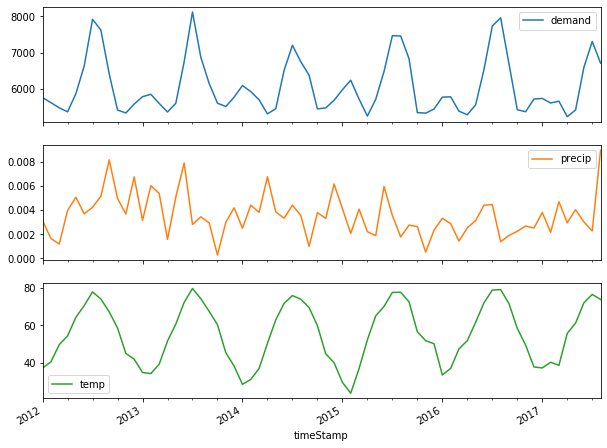

In [11]:
avg_df.plot(subplots = True, figsize = (10,8))

###### Insight:
    There is a seasonality in the 'demand'. It follows the trend with the 'temp'. As the temp increases, demand for energy is up (air conditioners, coolers etc) 

### Choosing the right model for forecasting

!pip install pmdarima

Given any time series data, check if its stationary using ADF or KPSS. If not stationary, use diff or shift to de-trend it and make it weakly stationary. Choose the best value for p,d,q (p for auto regression, d = differences, q for mong averages) such that the ARIMA or Seasonal ARIMA provides the least AIC value![the above steps are covered in Auto ARIMA] Fit the training data on this model and use it for prediction. 

In [12]:
import pmdarima as pm

In [13]:
model = pm.auto_arima(avg_df['demand'], m = 12, seasonal = True, start_p = 0, start_q = 0, max_order = 4, test = 'adf',error_action = 'ignore', suppress_warnings = True, stepwise = True, trace = True)

# data chosen is the monthly averaged demand data, we need to prepare model for 12 months(periodicity)!
# Since the data is seasonal, it should be set true
# start performing the tests with p=0,q=0 upto 4 orders
# test used to check the stationarity of series is ADF

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1100.321, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1023.735, Time=0.37 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1380.758, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1065.516, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1025.442, Time=0.94 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1101.718, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1014.059, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1021.211, Time=0.12 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1013.799, Time=1.13 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   68
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                -490.572
Date:                                 Fri, 30 Oct 2020   AIC                            993.144
Time:                                         22:24:31   BIC                           1006.461
Sample:                                              0   HQIC                           998.420
                                                  - 68                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3721.6223    792.259      4.697      0.000    2168.823    5274.421
ar.L1          0.8586      0.123      6.985      0.000       0.618       1.099
ar.L2         -0.4748      0.142     -3.352      0.001      -0.752      -0.197
ma.S.L12       0.8923      0.137      6.501      0.000       0.623       1.161
ma.S.L24       0.4571      0.206      2.222      0.026       0.054       0.860
sigma2      9.046e+04   1.58e+04      5.726      0.000    5.95e+04    1.21e+05
===================================================================================
Ljung-Box (Q):                       64.20   Jarque-Bera (JB):                 5.55
Prob(Q):                              0.01   Prob(JB):                         0.06
Heteroskedasticity (H):               0.78   Skew:                             0.52
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here, the best model for the forecasting is chosen as 'SARIMAX' with p = 2, d = 0, q = 0. Let's try to use this model to check if it could forecast properly!

In [15]:
#splitting data into training and testing set

train = avg_df.iloc[:-5,:] # everything apart from last 5 rows
test = avg_df.iloc[-5:,:] # last 5 rows

In [16]:
test

,demand,precip,temp
timeStamp,,,
2017-04-30,5233.477382,0.002942,55.621764
2017-05-31,5421.773060,0.004031,61.115457
2017-06-30,6597.990346,0.003008,71.962625
2017-07-31,7306.861511,0.002272,76.395270
2017-08-31,6711.707542,0.008961,73.730258


In [17]:
model.fit(train['demand'])

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [18]:
# lets predict for the 5 months which corresponds to the test index!
forecast = model.predict(n_periods = 5, return_conf_int = True) #setting the confidence interval to be 95%!

forecast

(array([5810.63255844, 5853.15676019, 6399.90534654, 7134.99190387,
        7153.5374123 ]),
 array([[5227.6977963 , 6393.56732059],
        [5065.28050266, 6641.03301772],
        [5590.12237173, 7209.68832136],
        [6319.30284665, 7950.6809611 ],
        [6317.42602668, 7989.64879792]]))

here forecast[0] array is the predicted result and forecast[1] array is the confidence interval(lower and upper bound!)

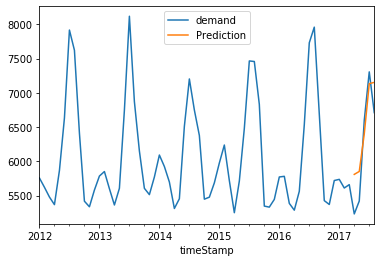

In [19]:
forecast_df = pd.DataFrame(forecast[0], index = test.index, columns = ['Prediction'])

pd.concat([avg_df['demand'], forecast_df], axis = 1).plot()

Here the orange line seems to fit the demand curve...let's try to verify if this worked properly or not by predicting for next 2 years!

In [20]:
from pandas.tseries.offsets import DateOffset

future_dates = [avg_df.index[-5]+ DateOffset(months = x)for x in range(0,24)]
future_dates

# You can also generate the date offsets using the pandas date_range
# pd.date_range(start='provide start date', periods = (specify the number of months, 24) , freq = 'M')

[Timestamp('2017-04-30 00:00:00'),
 Timestamp('2017-05-30 00:00:00'),
 Timestamp('2017-06-30 00:00:00'),
 Timestamp('2017-07-30 00:00:00'),
 Timestamp('2017-08-30 00:00:00'),
 Timestamp('2017-09-30 00:00:00'),
 Timestamp('2017-10-30 00:00:00'),
 Timestamp('2017-11-30 00:00:00'),
 Timestamp('2017-12-30 00:00:00'),
 Timestamp('2018-01-30 00:00:00'),
 Timestamp('2018-02-28 00:00:00'),
 Timestamp('2018-03-30 00:00:00'),
 Timestamp('2018-04-30 00:00:00'),
 Timestamp('2018-05-30 00:00:00'),
 Timestamp('2018-06-30 00:00:00'),
 Timestamp('2018-07-30 00:00:00'),
 Timestamp('2018-08-30 00:00:00'),
 Timestamp('2018-09-30 00:00:00'),
 Timestamp('2018-10-30 00:00:00'),
 Timestamp('2018-11-30 00:00:00'),
 Timestamp('2018-12-30 00:00:00'),
 Timestamp('2019-01-30 00:00:00'),
 Timestamp('2019-02-28 00:00:00'),
 Timestamp('2019-03-30 00:00:00')]

In [21]:
future_df = pd.DataFrame(index = future_dates[:],columns = avg_df.columns)
future_df.tail()

,demand,precip,temp
2018-11-30,NaN,NaN,NaN
2018-12-30,NaN,NaN,NaN
2019-01-30,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN
2019-03-30,NaN,NaN,NaN


In [22]:
forecast_2yr = model.predict(n_periods = 24, return_conf_int = True)

forecast_2yr[0]

array([5810.63255844, 5853.15676019, 6399.90534654, 7134.99190387,
       7153.5374123 , 6309.03012011, 5787.58758424, 5743.84922273,
       6006.18330869, 5925.41138613, 5734.14046924, 5925.55663631,
       6078.85385116, 6003.62229449, 6198.47030486, 6375.92472353,
       6385.00818148, 6080.52128378, 6008.76209192, 6005.82544992,
       6131.73970158, 6048.08733024, 5999.33576704, 6100.95612682])

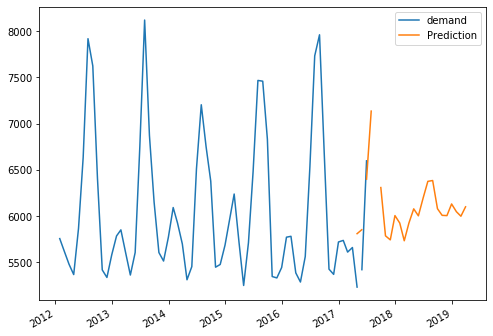

In [23]:
future_df['Prediction'] = forecast_2yr[0]

pd.concat([avg_df['demand'], future_df['Prediction']], axis = 1).plot(figsize = (8,6))

In [24]:
# Plotting the confidence interval!

lower = pd.Series(forecast_2yr[1][:, 0], index = future_df.index)
upper = pd.Series(forecast_2yr[1][:, 1], index = future_df.index)

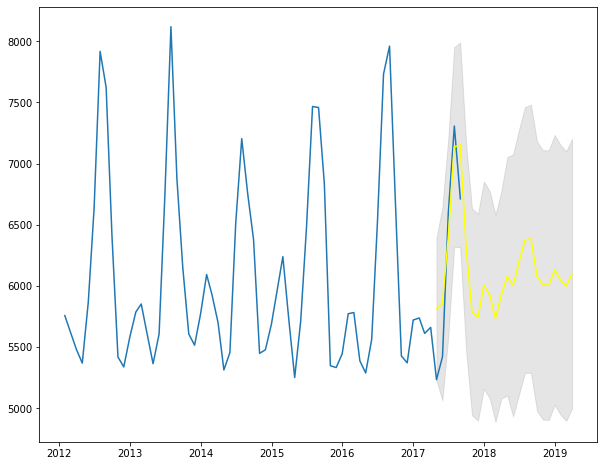

In [25]:
plt.figure(figsize = (10,8))
plt.plot(avg_df['demand'])
plt.plot(future_df['Prediction'], color='yellow')
plt.fill_between(future_df.index,lower, upper, color = 'gray', alpha = 0.2)

To check if the forecasting is correct or not, plot the residue. If the residue if of the white-noise type then the prediction is acceptable!

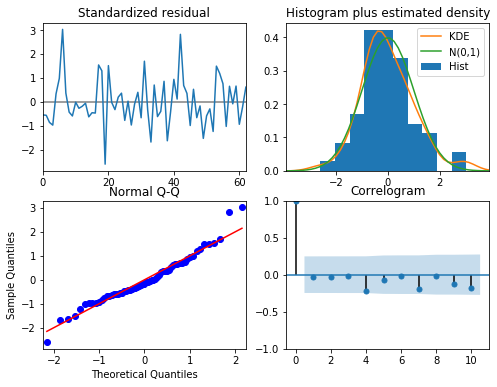

In [26]:
out = model.plot_diagnostics(figsize = (8,6))